In [202]:
# Package imports
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import math
import pdb
import pickle


#### Interesting Results with conf:
# batch_size = 50
# num_epochs = 100
# n_folds = 1
# lr = 0.01
# featx = 96
# def mlp(input_,input_dim,output_dim,name="mlp"):
#     with tf.variable_scope(name):
#         w = tf.get_variable('w',[input_dim,output_dim],tf.float32,tf.random_normal_initializer(mean = 0.0001,stddev=0.001))
#         #w = tf.get_variable('w',[input_dim,output_dim],tf.float32,tf.contrib.layers.xavier_initializer())
#         return tf.nn.tanh(tf.matmul(input_,w))
# node_sizes = {'input':featx,'l1':50,'l2':50,'output':2,'kernel_dim':5,'max_pool_redux_factor':16}

In [457]:
# Model Architecture Defs

#MLP
def build_model(X_,_dropout,node_sizes,net_type):
    if net_type == 'mlpnet':
        model = mlpnet(X_,_dropout,node_sizes)
    elif net_type == 'convnet':
        model = convnet(X_,_dropout,node_sizes)
    else: 
        print('unknown net architecture type')
    return model

def mlpnet(image,_dropout,node_sizes):
    l1 = mlp(image,node_sizes['input'],node_sizes['l1'],name='l1')
    l1 = tf.nn.dropout(l1,_dropout)
    l2 = mlp(l1,node_sizes['l1'],node_sizes['l2'],name='l2')
    l2 = tf.nn.dropout(l2,1)
#     l3 = mlp(l2,node_sizes['l2'],node_sizes['l3'],name='l3')
#     l3 = tf.nn.dropout(l3,1)
    l4 = mlp(l2,node_sizes['l2'],node_sizes['output'],name='l4')
    return l4

def mlp(input_,input_dim,output_dim,name="mlp"):
    with tf.variable_scope(name):
        #w = tf.get_variable('w',[input_dim,output_dim],tf.float32,tf.random_normal_initializer(mean = 0.001,stddev=0.02))
        w = tf.get_variable('w',[input_dim,output_dim],tf.float32,tf.contrib.layers.xavier_initializer())
        return tf.nn.relu(tf.matmul(input_,w))

#Convnet
def convnet(X_,_dropout,node_sizes):
    image_dim = int(np.sqrt(node_sizes['input']))
    final_image_vector_size = node_sizes['input']/node_sizes['max_pool_redux_factor']
    
    X_image = tf.reshape(X_, [-1,image_dim,image_dim,1])
    l1 = conv(X_image,node_sizes['kernel_dim'], 1, node_sizes['l1'], name='l1')  
    l1 = tf.nn.dropout(l1,_dropout)
    l2 = conv(l1,node_sizes['kernel_dim'], node_sizes['l1'], node_sizes['l2'], name='l2')
    l2 = tf.nn.dropout(l2,_dropout)
    
    #reshape to vector (reduced image size*number of filters)
    l2_flat = tf.reshape(l2, [-1, final_image_vector_size*node_sizes['l2']])    
    l3 = mlp(l2_flat,final_image_vector_size*node_sizes['l2'],node_sizes['output'],name='mlp')    
    #l3 = tf.nn.dropout(l3,_dropout) #Doesnt work well
    return l3
    
def conv(input_, kernel_dim, in_channels, output_dim,name="conv"):
    with tf.variable_scope(name):
        W = tf.get_variable('w',[kernel_dim, kernel_dim, in_channels, output_dim],
                            tf.float32,tf.random_normal_initializer(mean = 0.01,stddev=0.02))
        b = tf.get_variable('b',[output_dim],tf.float32,tf.constant_initializer(0.1))                        
        h_conv = tf.nn.relu(conv2d(input_, W) + b)
        h_pool = max_pool_2x2(h_conv)
        return h_pool
    
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
# def weight_variable(shape):
#     initial = tf.truncated_normal(shape, stddev=0.1)
#     return tf.Variable(initial)

# def bias_variable(shape):
#     initial = tf.constant(0.1, shape=shape)
#     return tf.Variable(initial)

# Loss and accuracy
def contrastive_loss(y,d,score_mod,use_mod):
    use_mod = False
    if use_mod:
        tmp= y *tf.square(d*score_mod)
        #tmp= tf.mul(y,tf.square(d))
        tmp2 = (1-y) *tf.square(tf.maximum((1 - d*score_mod),0))
    else:
        tmp= y *tf.square(d)
        #tmp= tf.mul(y,tf.square(d))
        tmp2 = (1-y) *tf.square(tf.maximum((1 - d),0))
        
    return tf.reduce_sum(tmp +tmp2)/batch_size/2

def compute_accuracy(prediction,labels):
    return labels[prediction.ravel() < 0.5].mean()
    #return tf.reduce_mean(labels[prediction.ravel() < 0.5])
    
def next_batch(s,e,inputs,labels,score_diff):
    input1 = inputs[s:e,0]
    input2 = inputs[s:e,1]        
    y = np.reshape(labels[s:e],(len(range(s,e)),1))
    score_mod = np.reshape(score_diff[s:e],(len(range(s,e)),1))
    return input1,input2,y,score_mod

def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    left_digits = []
    right_digits = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i+1]
            pairs += [[x[z1], x[z2]]]            
            left_digits.append(d)
            right_digits.append(d)            
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            left_digits.append(d)
            right_digits.append(dn)
    return np.array(pairs), np.array(labels), np.array(left_digits), np.array(right_digits)


In [201]:
import tables as tb
def load_data(data_path, input_node):
    data = tb.open_file(data_path, 'r')
    X = data.get_node('/' + input_node)[:]
    data.close()
    return X

def create_adni_pairs(X_L,X_R,y):
    X_L_tr1 = X_L[y==0]
    X_L_tr2 = X_L[y==1]
    X_R_tr1 = X_R[y==0]
    X_R_tr2 = X_R[y==1]
    X_L_stack = np.vstack((X_L, X_L_tr1,X_L_tr2, X_L_tr1,X_R_tr2))
    X_R_stack = np.vstack((X_R, X_R_tr2,X_R_tr1, X_L_tr2,X_R_tr1))
    y_traj_L = np.concatenate((y,np.zeros(X_L_tr1.shape[0]),np.ones(X_L_tr2.shape[0]),
                               np.zeros(X_L_tr1.shape[0]),np.ones(X_R_tr2.shape[0])))
    y_traj_R = np.concatenate((y,np.ones(X_R_tr2.shape[0]),np.zeros(X_R_tr1.shape[0]),
                               np.ones(X_L_tr2.shape[0]),np.zeros(X_R_tr1.shape[0])))    
    y_stack = np.concatenate((np.ones(len(y)),np.zeros(2*len(y))))
    
    #Shuffle
    idx = np.arange(3*len(y))
    np.random.shuffle(idx)
    X_L_stack_shuff = X_L_stack[idx,:]
    X_R_stack_shuff = X_R_stack[idx,:]
    pairs = np.concatenate((X_L_stack_shuff[:,np.newaxis,:],X_R_stack_shuff[:,np.newaxis,:]),axis=1)
    
    y_traj_L_shuff = y_traj_L[idx]
    y_traj_R_shuff = y_traj_R[idx]
        
    y_stack_shuff = y_stack[idx]

    return pairs, y_stack_shuff, y_traj_L_shuff, y_traj_R_shuff
    

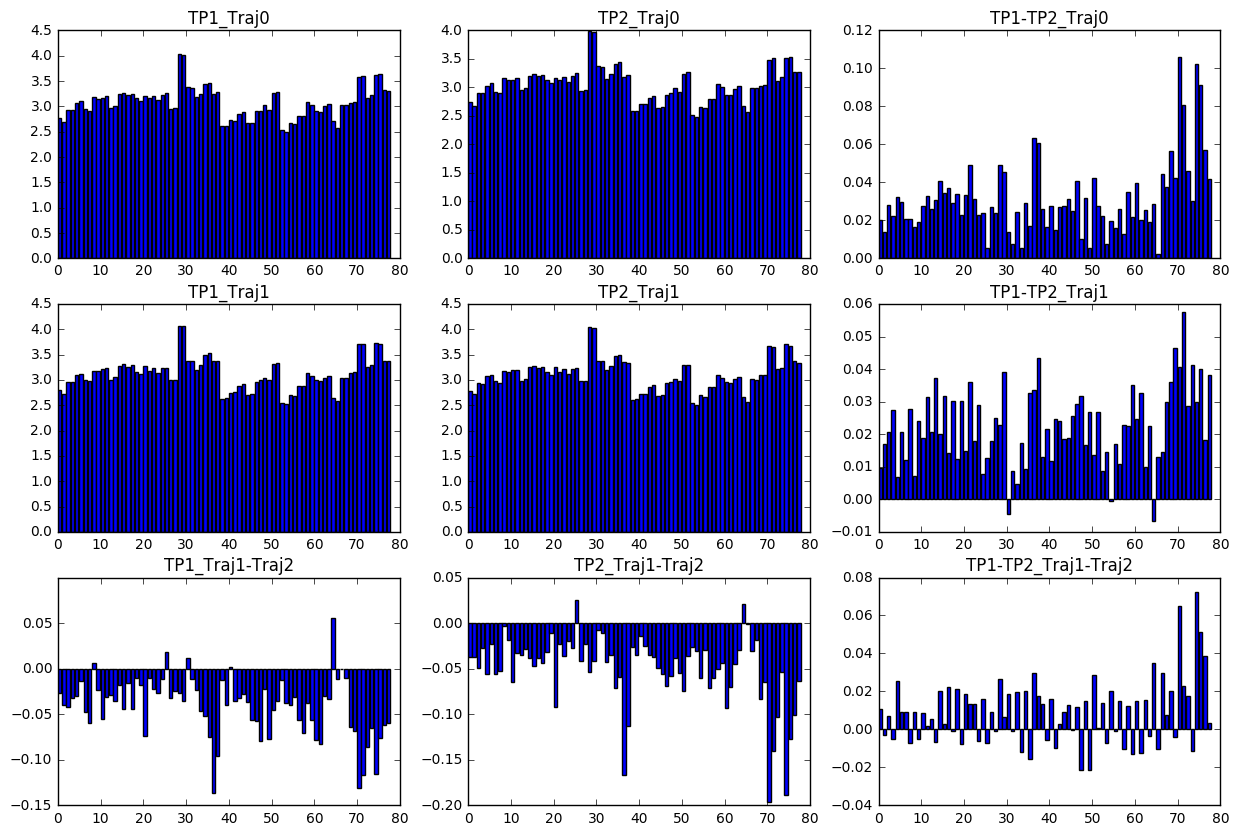

In [438]:
#Check data distributions
plt.rcParams['figure.figsize'] = (15, 10)
X_L = in_data['X_L_train'][:,18:]
X_R = in_data['X_R_train'][:,18:]
y = in_data['y_train']
featx = X_L.shape[1]

for traj in [0,1]:
    plt.subplot(3,3,traj*3+1)
    plt.bar(range(featx),np.mean(X_L[y==traj],axis=0))
    plt.title('TP1_Traj'+str(traj))
    plt.subplot(3,3,traj*3+2)    
    plt.bar(range(featx),np.mean(X_R[y==traj],axis=0))
    plt.title('TP2_Traj'+str(traj))
    plt.subplot(3,3,traj*3+3)
    plt.bar(range(featx),np.mean(X_L[y==traj]-X_R[y==traj],axis=0))
    plt.title('TP1-TP2_Traj'+str(traj))
    
traj=2
plt.subplot(3,3,traj*3+1)
plt.bar(range(featx),np.mean(X_L[y==0],axis=0)-np.mean(X_L[y==1],axis=0))
plt.title('TP1_Traj1-Traj2')
plt.subplot(3,3,traj*3+2)
plt.bar(range(featx),np.mean(X_R[y==0],axis=0)-np.mean(X_R[y==1],axis=0))
plt.title('TP2_Traj1-Traj2')
plt.subplot(3,3,traj*3+3)
plt.bar(range(featx),np.mean(X_L[y==0]-X_R[y==0],axis=0)-np.mean(X_L[y==1]-X_R[y==1],axis=0))
plt.title('TP1-TP2_Traj1-Traj2')

In [440]:
print 0.08/4
print 2./900

0.02
0.00222222222222


In [463]:
#ADNI2 datasets
baseline_dir = '/projects/nikhil/ADNI_prediction/input_datasets/longitudinal_trajectories/exp_setup/'
exp_file = 'CV_paired_long_data.pkl'
in_data = pickle.load( open(baseline_dir+exp_file, "rb" ) )


batch_size = 100
num_epochs = 1000
n_folds = 1
lr = 0.002
keep_p = 1
featx = 78
use_mod = False
#global_step = tf.Variable(0,trainable=False)
#starter_learning_rate = 0.0001
#learning_rate = tf.train.exponential_decay(starter_learning_rate,global_step,10,0.1,staircase=True)
train_loss = []
train_acc = []
valid_acc = []
test_acc = []

for fid in range(1,n_folds+1,1):    
#     train_file_path = baseline_dir + 'NN_setups/Traj_split_Exp6_MCI_ADNI2_ADAS13_BL_m06_scaled_siamese_fold_'+ str(fid) +'_train.h5'
#     test_file_path = baseline_dir + 'NN_setups/Traj_split_Exp6_MCI_ADNI2_ADAS13_BL_m06_scaled_siamese_fold_'+ str(fid) +'_test.h5'

#     X_L = load_data(train_file_path,'X_L')[:,:featx]
#     X_R = load_data(train_file_path,'X_R')[:,:featx]
#     y_traj = load_data(train_file_path,'y_traj')
    
#     print y_traj.shape    
#     pairs, y, y_traj_L, y_traj_R = create_adni_pairs(X_L,X_R,y_traj)    
#     print(pairs.shape, y.shape)
    
    X_L = in_data['X_L_train'][:,18:]
    X_R = in_data['X_R_train'][:,18:]
    pairs = np.concatenate((X_L[:,np.newaxis,:],X_R[:,np.newaxis,:]),axis=1)
    y = in_data['y_train']
    
    #Create train-validation sets
    tr_split = int(0.9*len(y))
    tr_pairs = pairs[:tr_split,:,:]
    va_pairs = pairs[tr_split:,:,:]
    tr_y = y[:tr_split]
    va_y = y[tr_split:]
    
#     tr_y_traj_L = y_traj_L[:tr_split]
#     tr_y_traj_R = y_traj_R[:tr_split]
#     va_y_traj_L = y_traj_L[tr_split:]
#     va_y_traj_R = y_traj_R[tr_split:]
    
        
    print(pairs.shape, tr_split, len(y))

#     test_X_L = load_data(test_file_path,'X_L')[:,:featx]
#     test_X_R = load_data(test_file_path,'X_R')[:,:featx]    
#     test_y_traj = load_data(test_file_path,'y_traj')    
#     te_pairs, te_y, te_y_traj_L, te_y_traj_R = create_adni_pairs(test_X_L,test_X_R,test_y_traj)
    
    X_L = in_data['X_L_test'][:,18:]
    X_R = in_data['X_R_test'][:,18:]
    te_pairs = np.concatenate((X_L[:,np.newaxis,:],X_R[:,np.newaxis,:]),axis=1)
    te_y = in_data['y_test']
    
    score_diff = tr_pairs[:,0,-1] - tr_pairs[:,1,-1]
    print(tr_pairs.shape,va_pairs.shape,te_pairs.shape,tr_y.shape,va_y.shape,te_y.shape)

    # Define input and model tensors + optimizer 
    #baseline_dir = '/projects/nikhil/ADNI_prediction/code/NI-ML/models/notebooks/MNIST_data/'
    #summary_writer = tf.train.SummaryWriter(baseline_dir + 'TF_log/', sess.graph_def)    
    #node_sizes = {'input':784,'l1':128,'l2':64, 'output':2,'kernel_dim':5,'max_pool_redux_factor':16}
    node_sizes = {'input':featx,'l1':50,'l2':50,'l3':0,'output':2,'kernel_dim':5,'max_pool_redux_factor':16}
    with tf.Graph().as_default():    
        images_L = tf.placeholder(tf.float32,shape=([None,node_sizes['input']]),name='L')
        images_R = tf.placeholder(tf.float32,shape=([None,node_sizes['input']]),name='R')
        labels = tf.placeholder(tf.float32,shape=([None,1]),name='gt')
        modulator = tf.placeholder(tf.float32,shape=([None,1]),name='md')
        
        dropout_f = tf.placeholder("float")

        with tf.variable_scope("siamese") as scope:
            model1= build_model(images_L,dropout_f,node_sizes,'mlpnet')
            scope.reuse_variables()
            model2 = build_model(images_R,dropout_f,node_sizes,'mlpnet')

        distance  = tf.sqrt(tf.reduce_sum(tf.pow(tf.sub(model1,model2),2),1,keep_dims=True))
        loss = contrastive_loss(labels,distance,modulator,use_mod)

        #contrastice loss
        t_vars = tf.trainable_variables()
        d_vars  = [var for var in t_vars if 'l' in var.name]
        batch = tf.Variable(0)
        optimizer = tf.train.AdamOptimizer(learning_rate = lr).minimize(loss)
        #optimizer = tf.train.RMSPropOptimizer(0.0001,momentum=0.9,epsilon=1e-6).minimize(loss)

        # Launch the graph
        with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
            #sess.run(init)
            tf.initialize_all_variables().run()
            # Training cycle
            for epoch in range(num_epochs):
                avg_loss = 0.
                avg_acc = 0.
                total_batch = int(tr_pairs.shape[0]/batch_size)
                start_time = time.time()
                # Loop over all batches
                for i in range(total_batch):
                    s  = i * batch_size
                    e = (i+1) *batch_size
                    
                    # Fit training using batch data
                    input1,input2,y,score_mod = next_batch(s,e,tr_pairs,tr_y, score_diff)           
                                
                    _,loss_value,predict=sess.run([optimizer,loss,distance], 
                                                  feed_dict={images_L:input1,images_R:input2,labels:y, 
                                                             modulator:score_mod,dropout_f:keep_p})

                    feature1=model1.eval(feed_dict={images_L:input1,dropout_f:keep_p})
                    feature2=model2.eval(feed_dict={images_R:input2,dropout_f:keep_p})

                    tr_acc = compute_accuracy(predict,y)
                    #print(tr_acc)
                    if math.isnan(tr_acc) and epoch != 0:
                        print('tr_acc %0.2f' % tr_acc)
                        pdb.set_trace()

                    avg_loss += loss_value
                    avg_acc +=tr_acc*100
                                        
                #print('epoch %d loss %0.2f' %(epoch,avg_loss/total_batch))
                duration = time.time() - start_time
                #print('epoch %d  time: %f loss %0.5f acc %0.2f' %(epoch,duration,avg_loss/(total_batch),avg_acc/total_batch))
                train_loss.append(avg_loss/(total_batch))
                train_acc.append(avg_acc/total_batch)
                
                #Check performance on validation set                                                                
                valid_feature_1 = model1.eval(feed_dict={images_L:va_pairs[:,0],dropout_f:1})
                valid_feature_2 = model2.eval(feed_dict={images_R:va_pairs[:,1],dropout_f:1})                
                y = np.reshape(va_y,(va_y.shape[0],1))
                predict=distance.eval(feed_dict={images_L:va_pairs[:,0],images_R:va_pairs[:,1],labels:y,dropout_f:1.0})                
                va_acc = compute_accuracy(predict,y)*100 
                valid_acc.append(va_acc)
                #print('Accuracy validation set %0.2f' % (va_acc))                

            #Accuracy of the entire training set at the end of training
            y = np.reshape(tr_y,(tr_y.shape[0],1))
            predict=distance.eval(feed_dict={images_L:tr_pairs[:,0],images_R:tr_pairs[:,1],labels:y,dropout_f:1.0})
            tr_acc = compute_accuracy(predict,y)
            print('Accuracy training set %0.2f' % (100 * tr_acc))
            print('Accuracy validation set %0.2f' % (va_acc))


            # Test model
            train_feature_1 = model1.eval(feed_dict={images_L:tr_pairs[:,0],dropout_f:1})
            train_feature_2 = model2.eval(feed_dict={images_R:tr_pairs[:,1],dropout_f:1})
            test_feature_1 = model1.eval(feed_dict={images_L:te_pairs[:,0],dropout_f:1})
            test_feature_2 = model2.eval(feed_dict={images_R:te_pairs[:,1],dropout_f:1})
            
            y = np.reshape(te_y,(te_y.shape[0],1))
            predict=distance.eval(feed_dict={images_L:te_pairs[:,0],images_R:te_pairs[:,1],labels:y,dropout_f:1.0})            
            te_acc = compute_accuracy(predict,y)
            test_acc.append(te_acc)
            print('Accuracy test set %0.2f' % (100 * te_acc))
        

((846, 2, 78), 761, 846)
((761, 2, 78), (85, 2, 78), (90, 2, 78), (761,), (85,), (90,))
Accuracy training set 72.61
Accuracy validation set 75.00
Accuracy test set 56.82


0.5
[0.5]


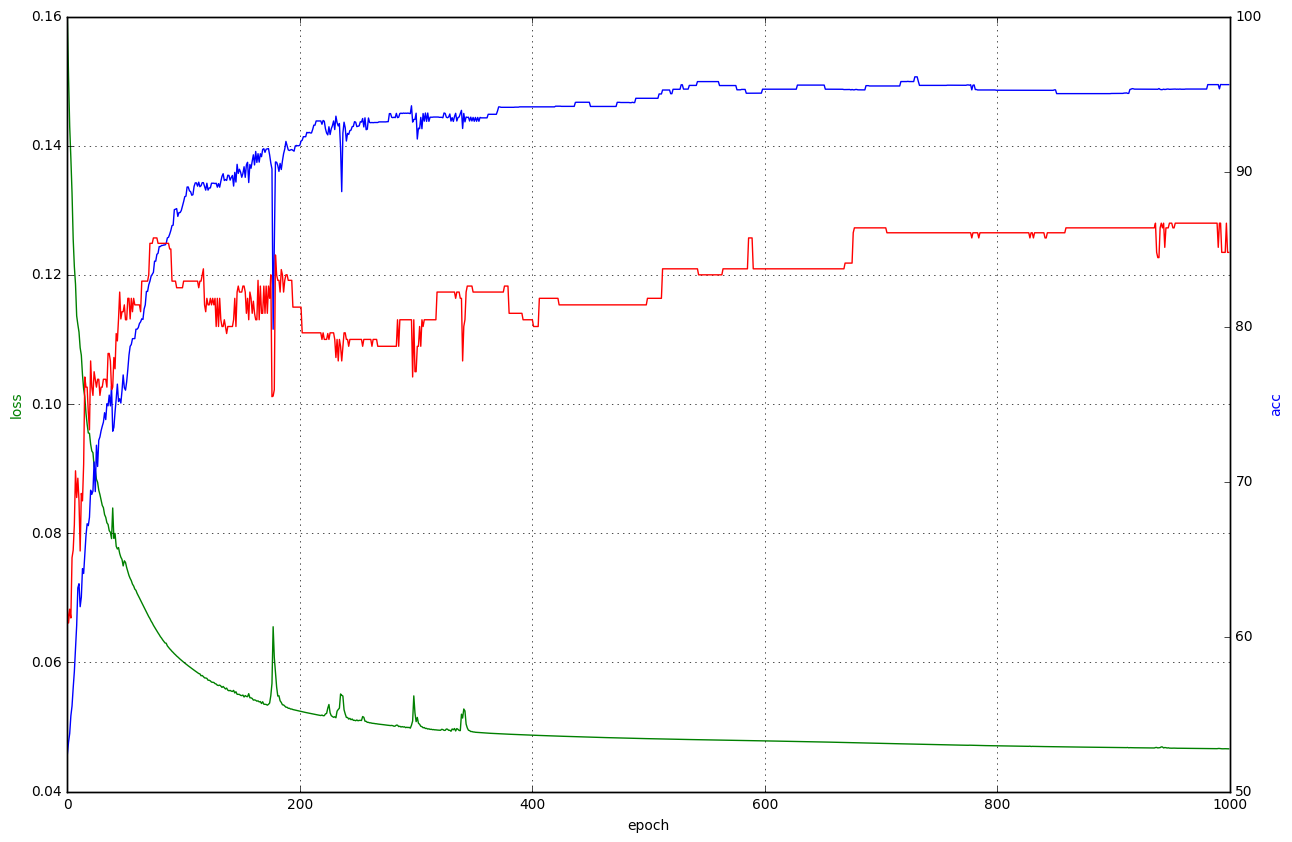

In [461]:
# Plot Acc and Loss
print np.mean(np.array(test_acc))
print(test_acc)
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(train_loss, 'g-')
ax2.plot(train_acc, 'b-')
ax2.plot(valid_acc, 'r-')


ax1.set_xlabel('epoch')
ax1.set_ylabel('loss', color='g')
ax2.set_ylabel('acc', color='b')
ax1.grid()


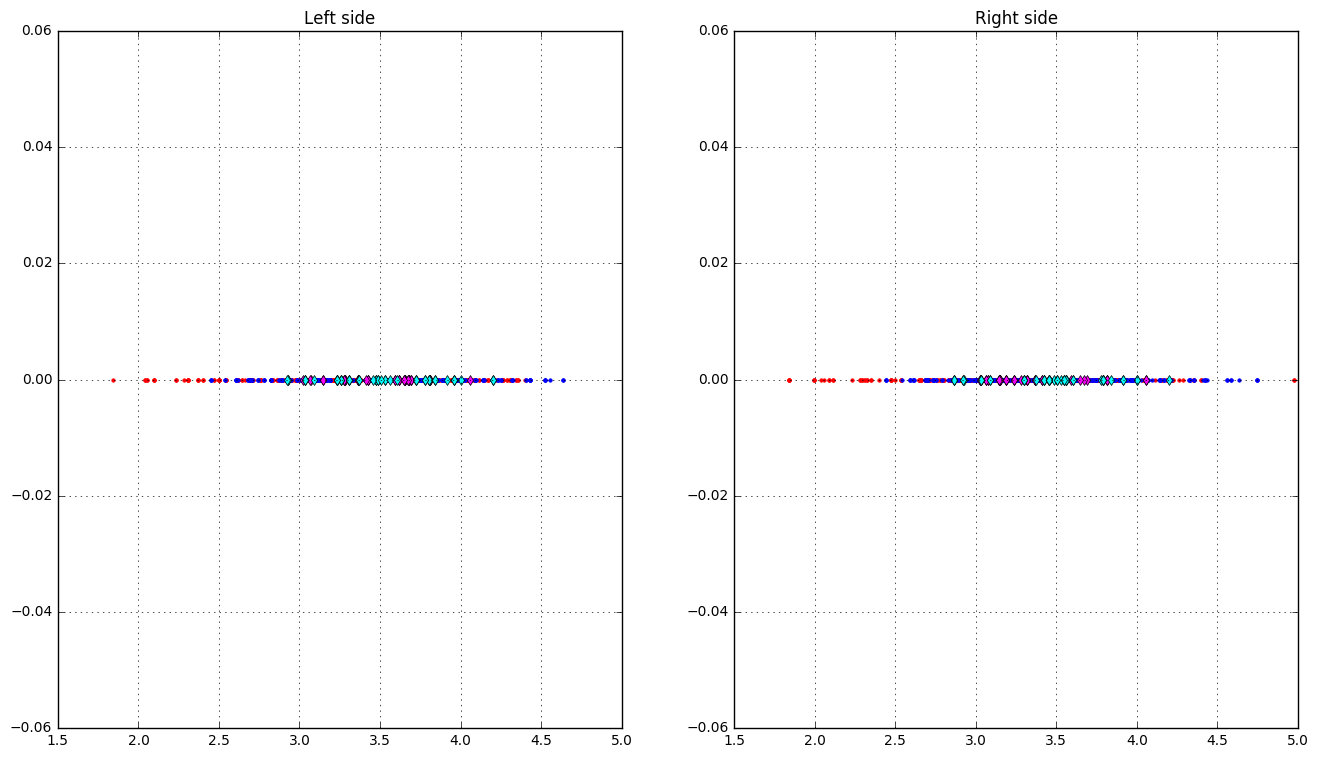

In [462]:
#Plot embeddings
f = plt.figure(figsize=(16,9))
c = ['#ff0000', '#0000ff', '#ffff00', '#00ff00', '#009999',
     '#ff00ff', '#00ffff', '#990000', '#999900', '#009900' ]
mark_size= 5

plt.subplot(1,2,1)
x = train_feature_1[:,0] 
y = train_feature_1[:,1] 
labels = tr_y #left_digits
for i in range(2):
    plt.plot(x[labels==i],y[labels==i],'.', c=c[i], markersize=mark_size)
    
x = test_feature_1[:,0] 
y = test_feature_1[:,1] 
labels = te_y #left_digits
for i in range(2):
    plt.plot(x[labels==i],y[labels==i],'d', c=c[i+5], markersize=mark_size)

    
#plt.legend(['train_class_1', 'train_class_2', 'test_class_1', 'test_class_2'],loc=1)
plt.grid()
plt.title('Left side')

plt.subplot(1,2,2)
x = train_feature_2[:,0] 
y = train_feature_2[:,1] 
labels = tr_y #right_digits
for i in range(2):
    plt.plot(x[labels==i],y[labels==i],'.', c=c[i], markersize=mark_size)

x = test_feature_2[:,0] 
y = test_feature_2[:,1] 
labels = te_y #right_digits
for i in range(2):
    plt.plot(x[labels==i],y[labels==i],'d', c=c[i+5], markersize=mark_size)

#plt.legend(['train_class_1', 'train_class_2', 'test_class_1', 'test_class_2'], loc=1)
plt.grid()
plt.title('Right side')

In [393]:
print np.sum(tr_y==0),np.sum(tr_y==1)
print np.sum(te_y==0),np.sum(te_y==1)

373 388
42 48


(array([  0.,   0.,   0.,   0.,   0.,  90.,   0.,   0.,   0.,   0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

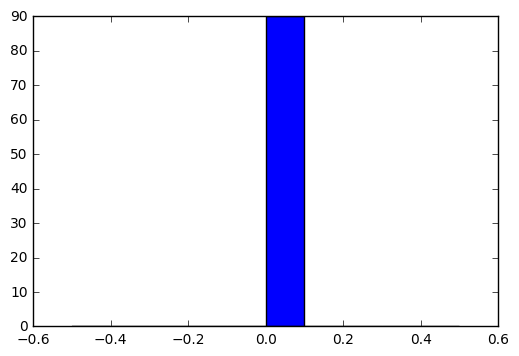

In [394]:
plt.hist(y)